## 测试一下系数回归
系数回归原理：

### 1.数据生成

Generated data (first 5 samples):
[[1.00496714 0.99861736]
 [1.02527485 0.99403094]
 [1.03480788 0.95490943]
 [1.07083997 0.94303419]
 [1.06779225 0.91856283]]


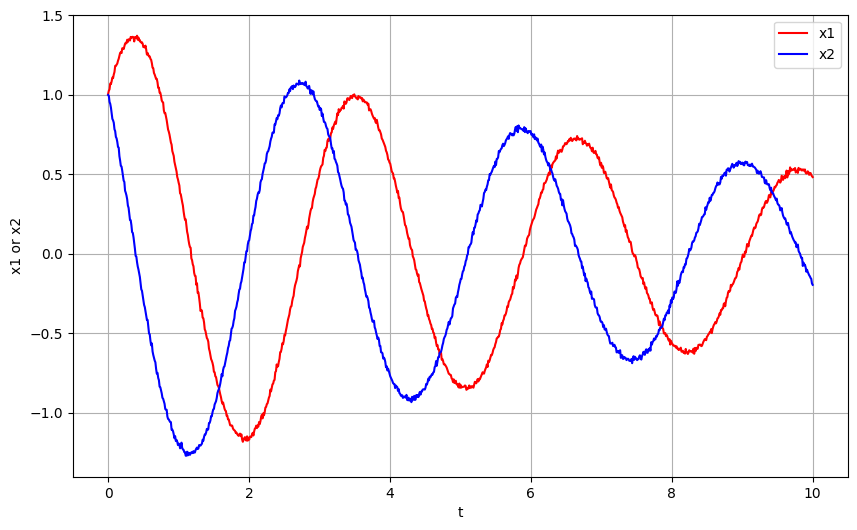

In [10]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# 定义二维线性系统
def linear_system(t, x):
    x1, x2 = x
    dx1dt = -0.1 * x1 + 2 * x2
    dx2dt = -2 * x1 - 0.1 * x2
    return [dx1dt, dx2dt]

# 生成时间序列数据
t_span = (0, 10)  # 时间范围
t_eval = np.linspace(t_span[0], t_span[1], 1000)  # 时间点
x0 = [1.0, 1.0]  # 初始条件

# 使用 solve_ivp 求解系统
sol = solve_ivp(linear_system, t_span, x0, t_eval=t_eval)
X = sol.y.T  # 状态变量 (x1, x2)
t = sol.t  # 时间点

# 添加噪声
np.random.seed(42)
noise_level = 0.01
X_noisy = X + noise_level * np.random.randn(*X.shape)

# 输出数据
print("Generated data (first 5 samples):")
print(X_noisy[:5])

plt.figure(figsize=(10, 6))
plt.plot(t_eval,X_noisy[:,0],color = "r",label = "x1")
plt.plot(t_eval,X_noisy[:,1],color = "b",label = "x2")
plt.xlabel("t")
plt.ylabel("x1 or x2")
plt.legend()
plt.grid(True)
plt.show()

### 2.数据平滑化
使用 Savitzky-Golay 滤波器平滑数据并计算导数


Smoothed data (first 5 samples):
[[1.00346202 1.00433886]
 [1.02138929 0.98168954]
 [1.03892966 0.95883719]
 [1.05607709 0.93578603]
 [1.07282553 0.91254024]]

Derivative data (first 5 samples):
[[ 0.0181187  -0.02254641]
 [ 0.01773483 -0.02275153]
 [ 0.01734491 -0.02295246]
 [ 0.01694894 -0.02314918]
 [ 0.01654693 -0.0233417 ]]


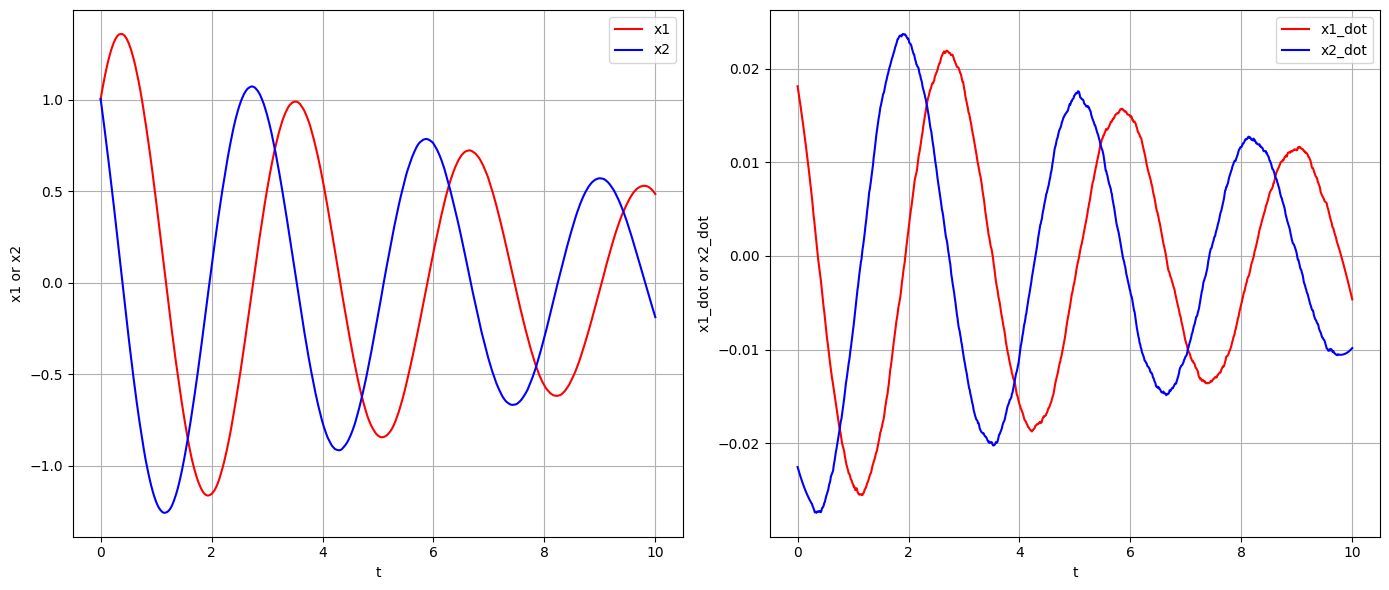

In [9]:
from scipy.signal import savgol_filter

# 使用 Savitzky-Golay 滤波器平滑数据并计算导数
window_length = 51  # 窗口长度
polyorder = 3  # 多项式阶数
X_smooth = savgol_filter(X_noisy, window_length, polyorder, axis=0)
X_dot = savgol_filter(X_noisy, window_length, polyorder, deriv=1, axis=0)

# 输出平滑后的数据
print("\nSmoothed data (first 5 samples):")
print(X_smooth[:5])

# 输出导数数据
print("\nDerivative data (first 5 samples):")
print(X_dot[:5])

fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 3x2 subplot layout
axes = axes.flatten()  # Flatten axes for easy iteration

axes[0].plot(t_eval,X_smooth[:,0],color = "r",label = "x1")
axes[0].plot(t_eval,X_smooth[:,1],color = "b",label = "x2")
axes[0].set_xlabel("t")
axes[0].set_ylabel("x1 or x2")
axes[0].legend()
axes[0].grid(True)

axes[1].plot(t_eval,X_dot[:,0],color = "r",label = "x1_dot")
axes[1].plot(t_eval,X_dot[:,1],color = "b",label = "x2_dot")
axes[1].set_xlabel("t")
axes[1].set_ylabel("x1_dot or x2_dot")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

### 3.定义系数矩阵

In [11]:
# 构建设计矩阵 (包含多项式项)
def build_design_matrix(X):
    n_samples, n_features = X.shape
    X1, X2 = X[:, 0], X[:, 1]
    # 设计矩阵包含 x1, x2, x1^2, x2^2, x1x2 等项
    Theta = np.column_stack([np.ones(n_samples), X1, X2, X1**2, X2**2, X1*X2])
    return Theta

Theta = build_design_matrix(X_smooth)

# 输出设计矩阵
print("\nDesign matrix (first 5 samples):")
print(Theta[:5])


Design matrix (first 5 samples):
[[1.         1.00346202 1.00433886 1.00693602 1.00869655 1.0078159 ]
 [1.         1.02138929 0.98168954 1.04323607 0.96371435 1.00268718]
 [1.         1.03892966 0.95883719 1.07937484 0.91936877 0.9961644 ]
 [1.         1.05607709 0.93578603 1.11529883 0.87569549 0.98826219]
 [1.         1.07282553 0.91254024 1.15095463 0.83272969 0.97899647]]


In [12]:
from sklearn.linear_model import Lasso

# 使用 Lasso 进行稀疏回归
def sparse_regression(Theta, X_dot):
    model = Lasso(alpha=0.01, max_iter=10000)  # Lasso 模型
    model.fit(Theta, X_dot)
    return model.coef_

# 对每个状态变量进行回归
coefficients_x1 = sparse_regression(Theta, X_dot[:, 0])
coefficients_x2 = sparse_regression(Theta, X_dot[:, 1])

# 输出结果
feature_names = ['1', 'x1', 'x2', 'x1^2', 'x2^2', 'x1x2']
print("\nIdentified equation for x1:")
print(f"dx1/dt = {coefficients_x1[0]:.2f} + {coefficients_x1[1]:.2f}x1 + {coefficients_x1[2]:.2f}x2 + "
      f"{coefficients_x1[3]:.2f}x1^2 + {coefficients_x1[4]:.2f}x2^2 + {coefficients_x1[5]:.2f}x1x2")

print("\nIdentified equation for x2:")
print(f"dx2/dt = {coefficients_x2[0]:.2f} + {coefficients_x2[1]:.2f}x1 + {coefficients_x2[2]:.2f}x2 + "
      f"{coefficients_x2[3]:.2f}x1^2 + {coefficients_x2[4]:.2f}x2^2 + {coefficients_x2[5]:.2f}x1x2")


Identified equation for x1:
dx1/dt = 0.00 + -0.00x1 + 0.00x2 + -0.00x1^2 + -0.00x2^2 + 0.00x1x2

Identified equation for x2:
dx2/dt = 0.00 + -0.00x1 + -0.00x2 + -0.00x1^2 + 0.00x2^2 + 0.00x1x2


# 测试完毕，表现效果十分良好。
## 关于课题使用的难点思考：
### 1.如何构建一个随机的组合项，构成生成矩阵？
对于牛顿引力微分方程：
$$
\begin{align}
\ddot{x} = -\frac{G M x}{(x^2 + y^2)^\frac{3}{2}} \\
\ddot{y} = -\frac{G M y}{(x^2 + y^2)^\frac{3}{2}}
\end{align}
$$


#### 1.虚拟数据集生成：

Generated dataset (first 5 rows):
[[ 0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
   9.50000000e-01 -1.00000000e+00 -0.00000000e+00]
 [ 1.00010001e-03  9.99999500e-01  9.50094851e-04 -1.00009989e-03
   9.49999525e-01 -9.99999646e-01 -9.50094990e-04]
 [ 2.00020002e-03  9.99998000e-01  1.90018875e-03 -2.00019908e-03
   9.49998100e-01 -9.99998585e-01 -1.90018986e-03]
 [ 3.00030003e-03  9.99995499e-01  2.85028075e-03 -3.00029685e-03
   9.49995724e-01 -9.99996816e-01 -2.85028450e-03]
 [ 4.00040004e-03  9.99991998e-01  3.80036990e-03 -4.00039249e-03
   9.49992398e-01 -9.99994339e-01 -3.80037880e-03]]


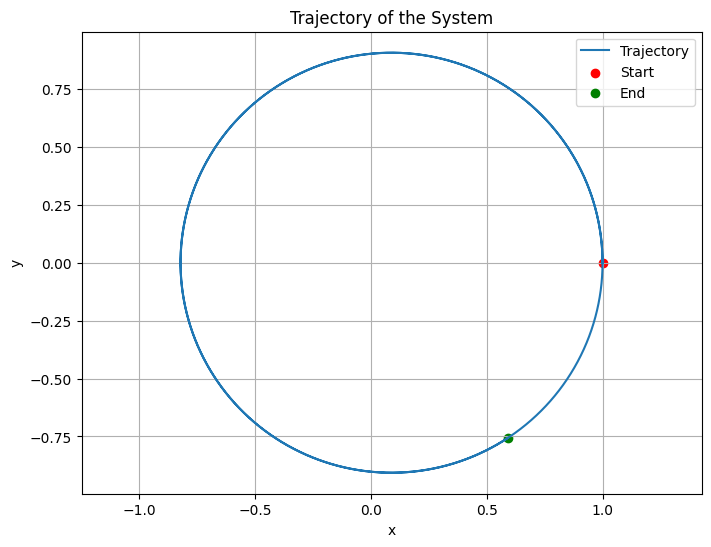

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# 定义常数
G = 1.0  # 万有引力常数
M = 1.0  # 中心质量

# 定义微分方程组
def equations(t, state):
    x, y, vx, vy = state  # 状态变量: x, y, vx, vy
    r = np.sqrt(x**2 + y**2)  # 距离
    dxdt = vx
    dydt = vy
    dvxdt = -G * M * x / r**3
    dvydt = -G * M * y / r**3
    return [dxdt, dydt, dvxdt, dvydt]

# 初始条件
x0 = 1.0  # 初始 x 位置
y0 = 0.0  # 初始 y 位置
vx0 = 0.0  # 初始 x 速度
vy0 = 0.95*np.sqrt(G * M / x0)  # 初始 y 速度 (确保椭圆轨迹)
initial_state = [x0, y0, vx0, vy0]

# 时间范围
t_span = (0, 10)  # 从 t=0 到 t=10
t_eval = np.linspace(t_span[0], t_span[1], 10000)  # 时间点 (增加时间点数量)

# 数值积分 (使用更高阶的积分方法)
sol = solve_ivp(equations, t_span, initial_state, t_eval=t_eval, method='DOP853', rtol=1e-10, atol=1e-10)

# 提取结果
t = sol.t  # 时间点
x = sol.y[0]  # x(t)
y = sol.y[1]  # y(t)
vx = sol.y[2]  # vx(t)
vy = sol.y[3]  # vy(t)

# 计算加速度 (二阶导数)
r = np.sqrt(x**2 + y**2)
ax = -G * M * x / r**3  # x 方向加速度
ay = -G * M * y / r**3  # y 方向加速度

# 生成数据集
data = np.column_stack([t, x, y, vx, vy, ax, ay])

# 输出数据集的前 5 行
print("Generated dataset (first 5 rows):")
print(data[:5])

# 可视化轨迹
plt.figure(figsize=(8, 6))
plt.plot(x, y, label='Trajectory')
plt.scatter(x[0], y[0], color='red', label='Start')
plt.scatter(x[-1], y[-1], color='green', label='End')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Trajectory of the System')
plt.legend()
plt.grid()
plt.axis('equal')  # 确保 x 和 y 轴比例相同
plt.show()

In [5]:
import numpy as np

# 假设我们有 n 个时间点的观测数据 (x, y)
n = 10000  # 时间点数量


# 定义候选基函数
def build_design_matrix(x, y):
    # 计算分母项
    denominator = (x**2 + y**2)**(3/2)
    
    # 构建设计矩阵
    Theta = np.column_stack([
        np.ones(n),  # 常数项
        x,           # x
        y,           # y
        x**2,        # x^2
        y**2,        # y^2
        x * y,       # x * y
        x * y**2,
        y * x**2,
        x / denominator,  # x / (x^2 + y^2)^(3/2)
        y / denominator   # y / (x^2 + y^2)^(3/2)
    ])
    return Theta

# 构建生成矩阵
Theta = build_design_matrix(x, y)

# 输出生成矩阵的前 5 行
print("Design matrix (first 5 rows):")
print(Theta[:5])

Design matrix (first 5 rows):
[[1.00000000e+00 1.00000000e+00 0.00000000e+00 1.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.00000000e+00 0.00000000e+00]
 [1.00000000e+00 9.99999500e-01 9.50094851e-04 9.99999000e-01
  9.02680226e-07 9.50094376e-04 9.02679775e-07 9.50093901e-04
  9.99999646e-01 9.50094990e-04]
 [1.00000000e+00 9.99998000e-01 1.90018875e-03 9.99995999e-01
  3.61071729e-06 1.90018495e-03 3.61071007e-06 1.90018115e-03
  9.99998585e-01 1.90018986e-03]
 [1.00000000e+00 9.99995499e-01 2.85028075e-03 9.99990998e-01
  8.12410037e-06 2.85026792e-03 8.12406380e-06 2.85025509e-03
  9.99996816e-01 2.85028450e-03]
 [1.00000000e+00 9.99991998e-01 3.80036990e-03 9.99983997e-01
  1.44428114e-05 3.80033949e-03 1.44426958e-05 3.80030908e-03
  9.99994339e-01 3.80037880e-03]]


In [6]:
from sklearn.linear_model import Lasso

# 假设我们有二阶导数数据 (x_ddot, y_ddot)
x_ddot = ax
y_ddot = ay

# 使用 LASSO 回归
lasso = Lasso(alpha=0.01)  # alpha 是正则化参数
lasso.fit(Theta, x_ddot)   # 拟合 x_ddot
coefficients_x = lasso.coef_

lasso.fit(Theta, y_ddot)   # 拟合 y_ddot
coefficients_y = lasso.coef_

# 输出回归系数
print("Coefficients for x_ddot:")
print(coefficients_x)

print("\nCoefficients for y_ddot:")
print(coefficients_y)

Coefficients for x_ddot:
[ 0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.98641239 -0.        ]

Coefficients for y_ddot:
[ 0.         -0.         -0.         -0.          0.         -0.
 -0.         -0.         -0.         -0.98732392]
